In [1]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price,calculate_r
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import cov_actual_IV,cov_estimated_IV
from dateutil.relativedelta import relativedelta
import math
import warnings
warnings.filterwarnings("ignore")

## Simulation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
975.9132339394134
trading_days_to_simulate: 253
Derivative Price for 2022-08-22 00:00:00
947.0086377651799
trading_days_to_simulate: 252
Derivative Price for 2022-08-23 00:00:00
922.0601530924388
trading_days_to_simulate: 251
Derivative Price for 2022-08-24 00:00:00
920.346618755067
trading_days_to_simulate: 250
Derivative Price for 2022-08-25 00:00:00
917.0918861857672
trading_days_to_simulate: 249
Derivative Price for 2022-08-26 00:00:00
943.1337481998033
trading_days_to_simulate: 248
Derivative Price for 2022-08-29 00:00:00
861.0639520662387
trading_days_to_simulate: 247
Der

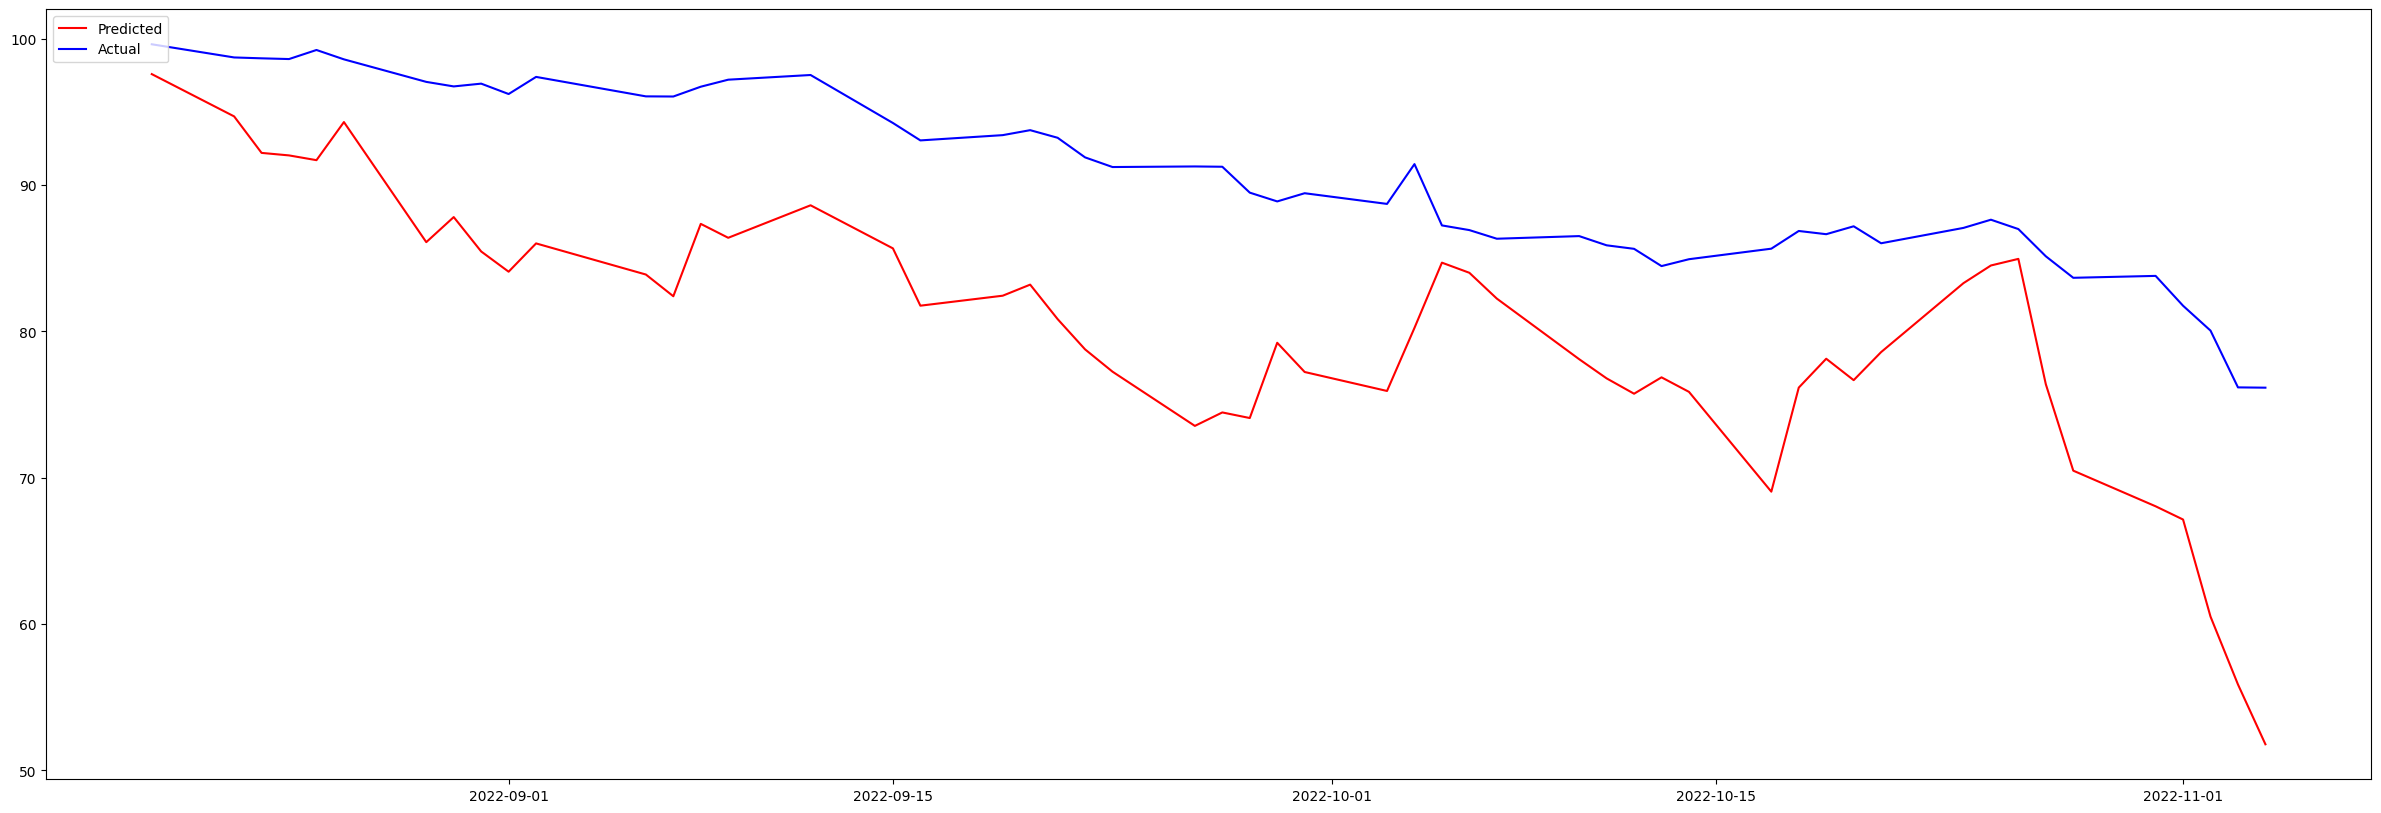

In [20]:
experiment_details = {
    'Nsim': 1000,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':False,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': False,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

## Visualisation

## Implied Volatility vs Historical Volatility Visualisation

In [21]:
historical_vol = sigma_list

In [22]:
hist_vol_df = pd.DataFrame(historical_vol,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
hist_vol_df['Type'] = 'Historical Volatility'

In [18]:
estimated_IV = sigma_list

In [19]:
estimated_IV_df = pd.DataFrame(estimated_IV,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
estimated_IV_df['Type'] = 'Estimated IV'

In [15]:
actual_IV = sigma_list

In [16]:
actual_IV_df = pd.DataFrame(actual_IV,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
actual_IV_df['Type'] = 'Actual IV'

In [23]:
pdList = [hist_vol_df,estimated_IV_df,actual_IV_df]
merged_vol_df = pd.DataFrame(columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
merged_vol_df = pd.concat(pdList,axis=0)

In [24]:
merged_vol_df

AAPL_Vol              AMZN_Vol             GOOGL_Vol  \
0    0.01916335495836022  0.027641208400446197   0.02095638755311791   
1    0.01924703511344626  0.027776422488322086  0.021043304673032247   
2   0.019267366341435728  0.027815085732463357  0.021060157562546665   
3    0.01922958148071035    0.0277606588750618   0.02101876293330044   
4   0.019229656652301218  0.027748933229995866   0.02101022036490459   
..                   ...                   ...                   ...   
50   0.02193694197173133  0.026770811512447406  0.023368881285535985   
51  0.021814866077905008   0.02612111295507347   0.02320709577837324   
52  0.021624491340710362  0.026131161786228665   0.02295319107286535   
53  0.021959536953166058   0.02631163858691256    0.0227998236183309   
54  0.024168661052628104  0.030165871829488194  0.023099482366758635   

          Date                   Type  
0   2022-08-19  Historical Volatility  
1   2022-08-22  Historical Volatility  
2   2022-08-23  Historical Volatility  
3   2022-08-24  Historical Volatility  
4   2022-08-25  Historical Volatility  
..         ...                    ...  
50  2022-10-31              Actual IV  
51  2022-11-01              Actual IV  
52  2022-11-02              Actual IV  
53  2022-11-03              Actual IV  
54  2022-11-04              Actual IV  

[165 rows x 5 columns]

In [25]:
temp = merged_vol_df.copy()
temp['AAPL_Vol'] = temp['AAPL_Vol'].astype('float')
temp['AMZN_Vol'] = temp['AMZN_Vol'].astype('float')
temp['GOOGL_Vol'] = temp['GOOGL_Vol'].astype('float')

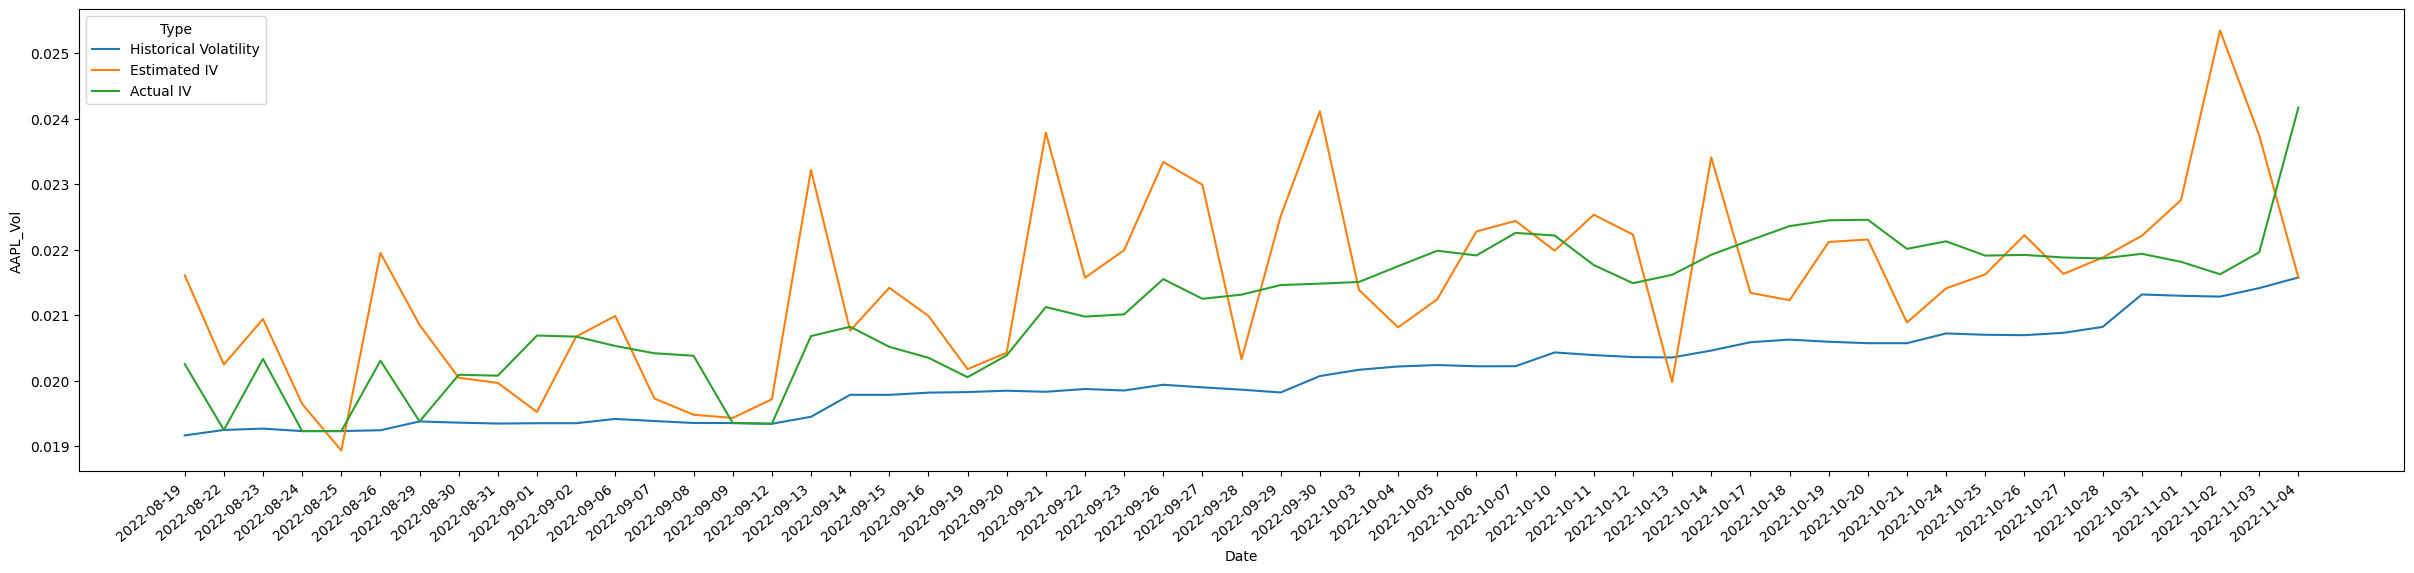

In [35]:
import seaborn as sns
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='AAPL_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/AAPL_Vol')

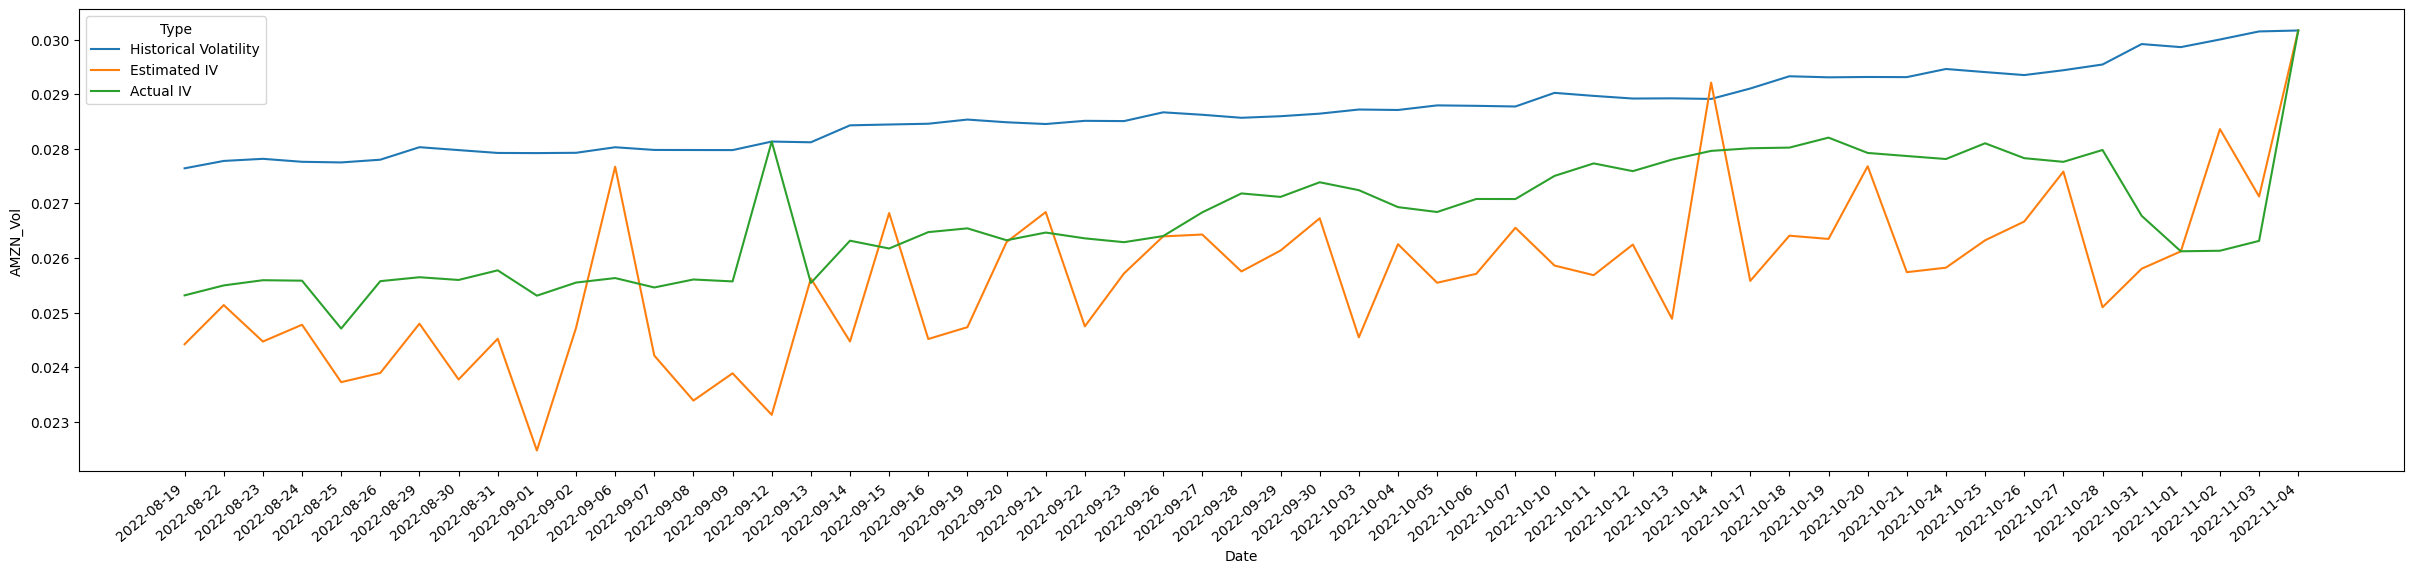

In [36]:
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='AMZN_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/AMZN_Vol')



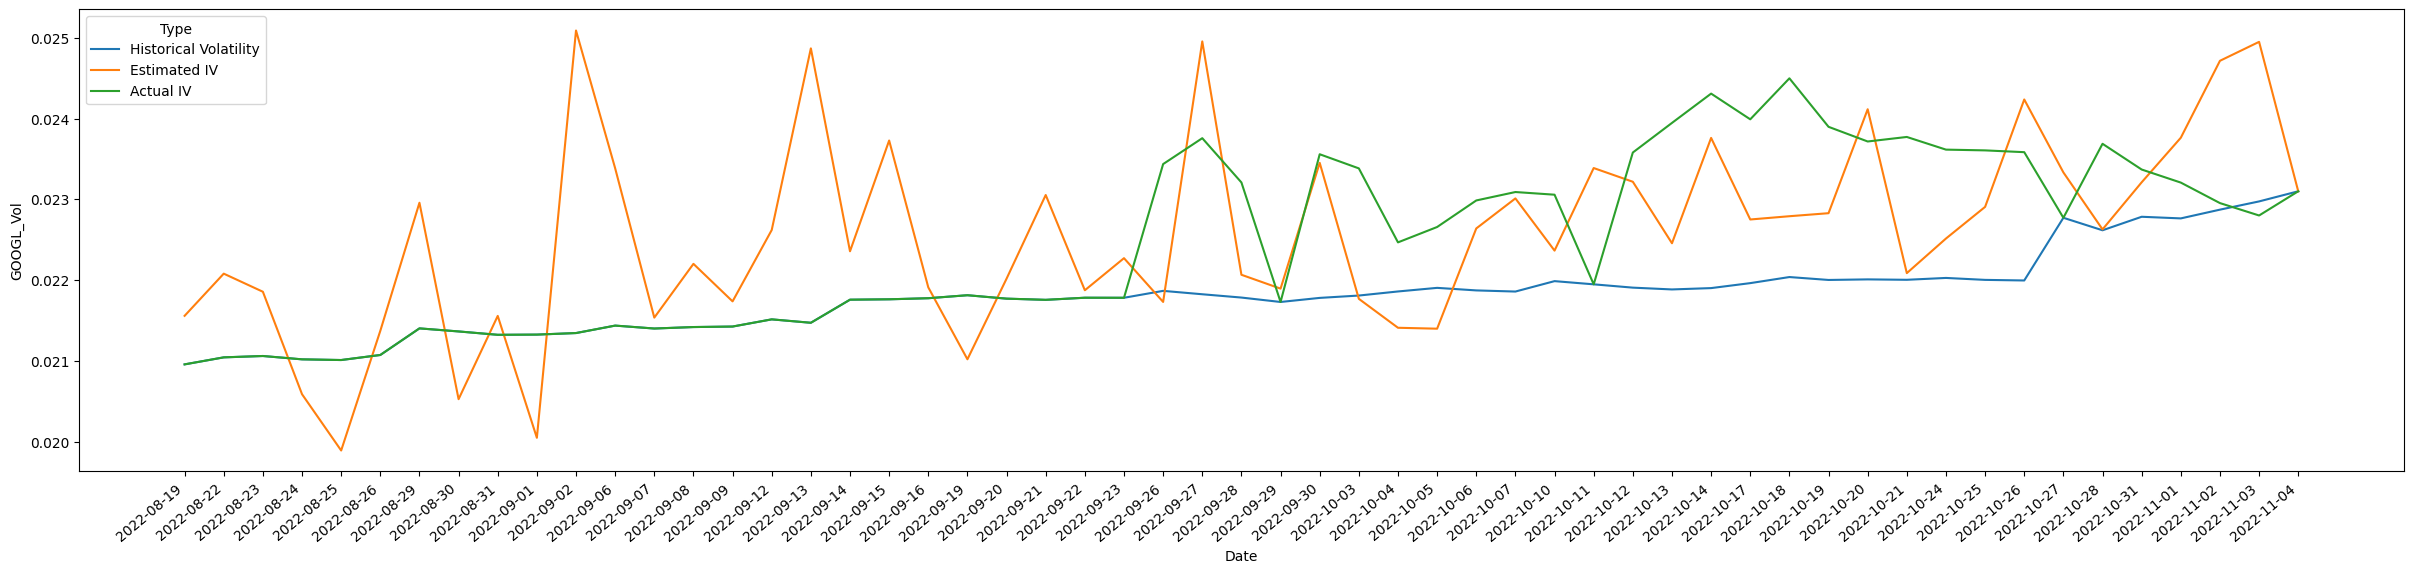

In [37]:
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='GOOGL_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/GOOGL_Vol')


# Experiments with Variance Reduction

## MC vs AV Simulation on Asset Prices

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Variance reduction
Derivative Price for 2022-08-19 00:00:00
980.1241701965872
trading_days_to_simulate: 253
Variance reduction
Derivative Price for 2022-08-22 00:00:00
949.2482437933721
trading_days_to_simulate: 252
Variance reduction
Derivative Price for 2022-08-23 00:00:00
886.7250992913166
trading_days_to_simulate: 251
Variance reduction
Derivative Price for 2022-08-24 00:00:00
907.5100884851396
trading_days_to_simulate: 250
Variance reduction
Derivative Price for 2022-08-25 00:00:00
911.9804770052359
trading_days_to_simulate: 249
Variance reduction
Derivative Price for 2022-08-26 00:00:00
918.9434769403904
trading

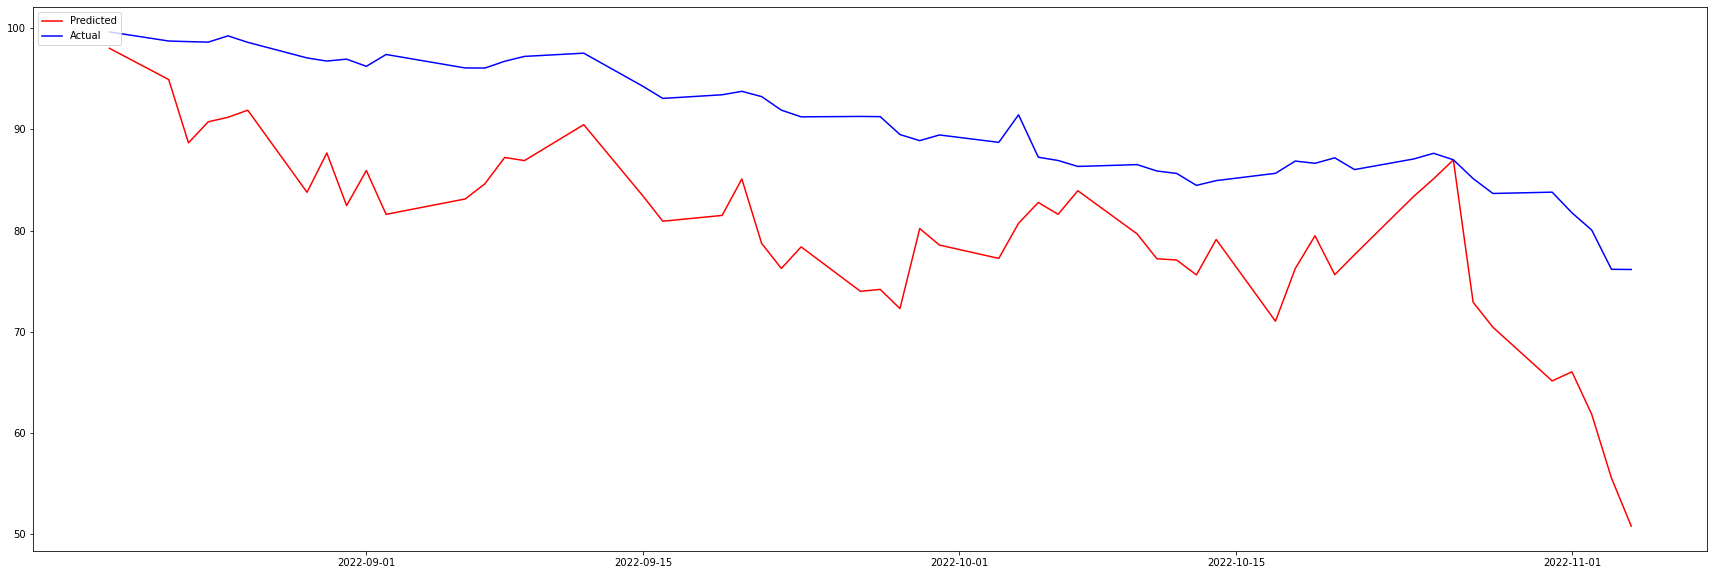

In [59]:
experiment_details = {
    'Nsim': 100,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':False,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': False,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        print('Variance reduction')
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

### AAPL AV Simulation

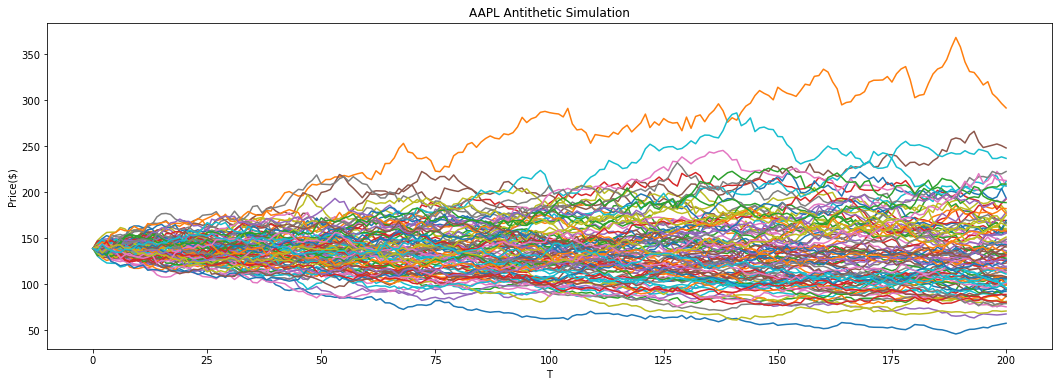

In [60]:
fig = plt.figure(figsize=(18,6))
for i in sim_aapl:
    plt.plot(i)
plt.title('AAPL Antithetic Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/AAPL_AV_simulated_price')

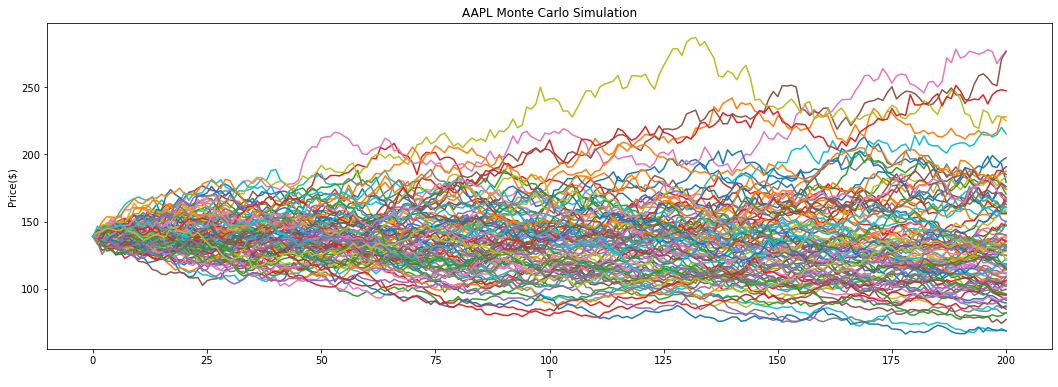

In [54]:
fig = plt.figure(figsize=(18,6))
for i in sim_aapl:
    plt.plot(i)
plt.title('AAPL Monte Carlo Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/AAPL_MC_simulated_price')

### AMZN AV Simulation

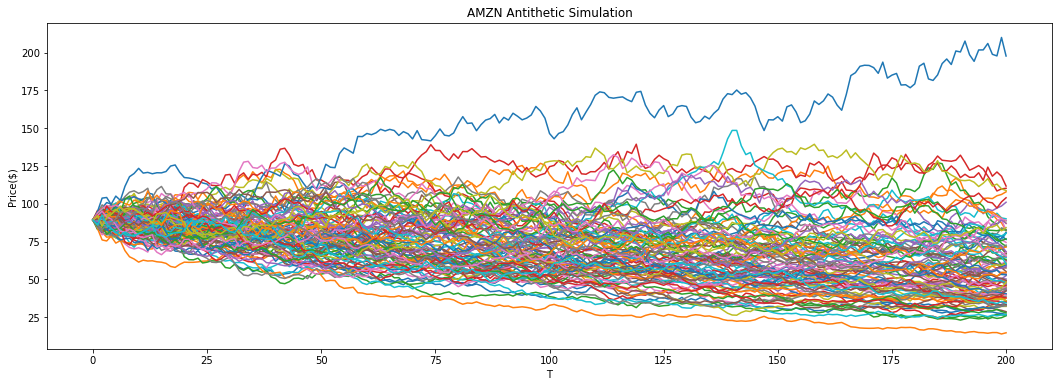

In [61]:
fig = plt.figure(figsize=(18,6))
for i in sim_amzn:
    plt.plot(i)
plt.title('AMZN Antithetic Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/AMZN_AV_simulated_price')

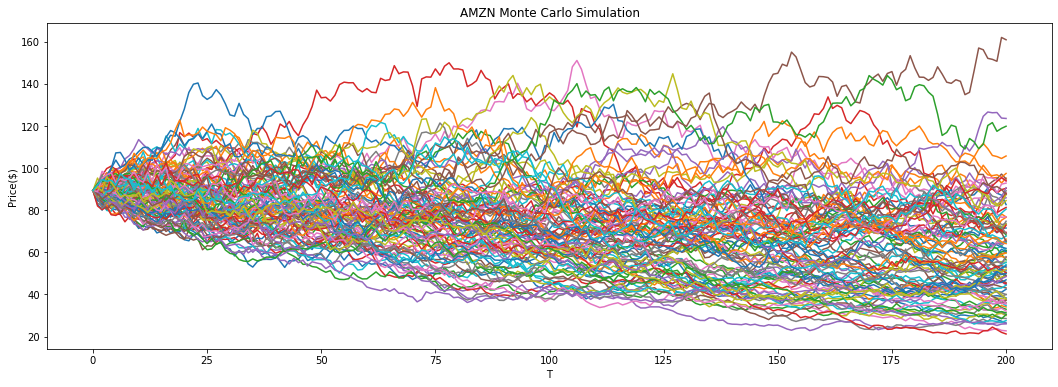

In [53]:
fig = plt.figure(figsize=(18,6))
for i in sim_amzn:
    plt.plot(i)
plt.title('AMZN Monte Carlo Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/AMZN_MC_simulated_price')

### GOOGL AV Simulation

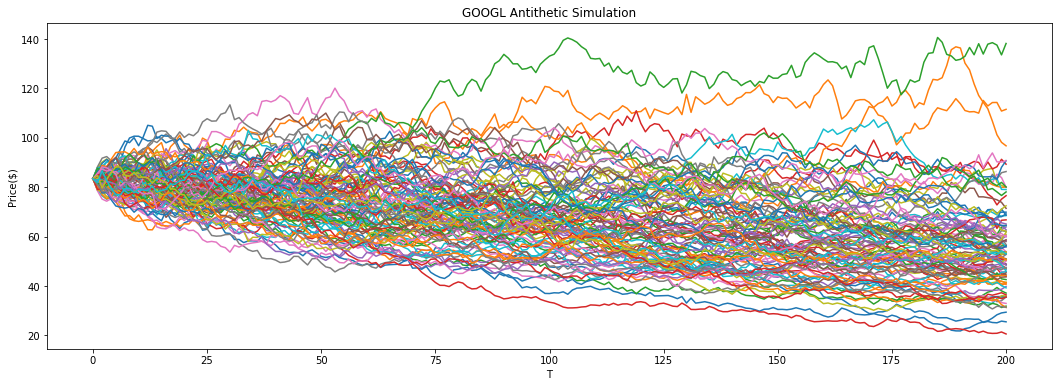

In [62]:
fig = plt.figure(figsize=(18,6))
for i in sim_googl:
    plt.plot(i)
plt.title('GOOGL Antithetic Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/GOOGL_AV_simulated_price')

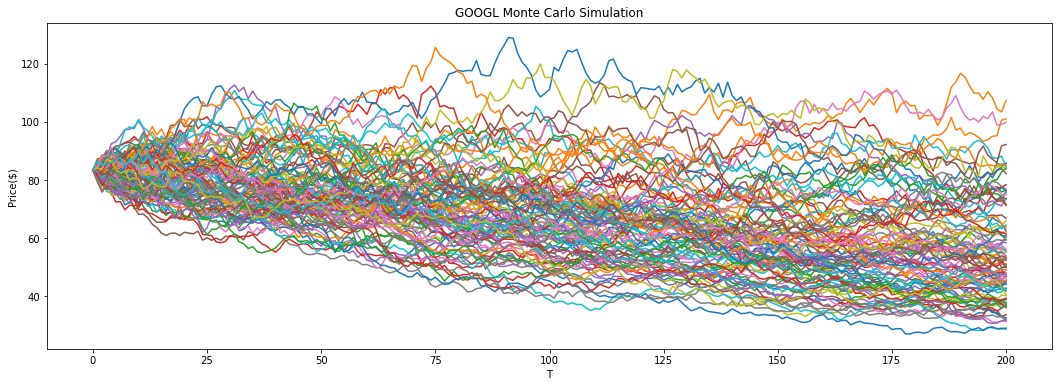

In [52]:
fig = plt.figure(figsize=(18,6))
for i in sim_googl:
    plt.plot(i)
plt.title('GOOGL Monte Carlo Simulation')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.savefig('../results/GOOGL_MC_simulated_price')

## Variance of Expected Payoff

In [132]:
n_sims = [x for x in range(50,2050,50)]

### MC Simulation

In [133]:
mc_var = {}
num_repeats = 100
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    mc_var[n_sim] = []
    for i in range(num_repeats):
        experiment_details = {
            'Nsim': n_sim,
            'latest_price_date': '2022-08-19',
            'variance_reduction': False,
            'GBM': 'multivariate',
            'r': 0.045,
            'IV': False,
            'min_sigma':0.0001,
            'max_sigma':5,
            'step':0.00001,
            'error':0.25,
            'EMS': False
        }

        aapl_barrier = 85.760
        amzn_barrier = 69.115
        googl_barrier = 58.605
        aapl_initial = 171.52
        amzn_initial = 138.23
        google_initial = 117.21

        date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
            latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
        trading_days_to_simulate = total_trading_days

        if experiment_details['IV']:

            aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
            aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
            amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
            amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
            googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
            googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

            min_sigma = experiment_details['min_sigma']
            max_sigma = experiment_details['max_sigma']
            error = experiment_details['error']
            step = experiment_details['step']
            sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
            right = len(sigma_hat_list)-1
            left = 0 

        predicted_option_price = []
        expected_payoff_list = []
        aapl_IV_list = []
        amzn_IV_list = []
        googl_IV_list = []

        while date_to_predict <= end_date:

            if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
                date_to_predict += relativedelta(days=+1)
                trading_days_to_simulate -= 1
                hist_end += relativedelta(days=+1)
                alternative_option_ttm-=1
                continue

            hist_start = hist_end - timedelta(days=365)

            aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
            amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
            googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
            temp_df = aapl.merge(amzn, on=['Date'])
            AAG = temp_df.merge(googl, on=['Date'])
            n0 = len(AAG)
            AAGprices = np.array(AAG.drop(columns=['Date']))
            AAGlogprices = np.log(AAGprices)
            AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

            v = np.mean(AAGlogreturns, axis=0)
            Nsim = experiment_details['Nsim']
            T = trading_days_to_simulate
            dt = 1
            m = int(T / dt)
            r = experiment_details['r']

            # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
            if experiment_details['IV']:
                sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
                aapl_IV_list.append(aapl_IV)
                amzn_IV_list.append(amzn_IV)
                googl_IV_list.append(googl_IV)
            else:
                sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

            S0 = AAGprices[0, :]
            sim_aapl = []
            sim_amzn = []
            sim_googl = []

            # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
            if experiment_details['variance_reduction']:
                for i in range(1, int(Nsim/2) + 1):
                    S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_aapl.append(Stilde[0])
                    sim_amzn.append(S[1])
                    sim_amzn.append(Stilde[1])
                    sim_googl.append(S[2])
                    sim_googl.append(Stilde[2])

            else:
                for i in range(1, Nsim + 1):
                    S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_amzn.append(S[1])
                    sim_googl.append(S[2])

            if experiment_details['EMS']:
                sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
                sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
                sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

            q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
            q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

            option_prices = []
            payoff_list = []
            for i in range(Nsim):
                option_price, payoff = calculate_option_price(
                        aapl=sim_aapl[i],
                        amzn=sim_amzn[i],
                        googl=sim_googl[i],
                        T=trading_days_to_simulate,
                        total_trading_days=total_trading_days,
                        r=r,
                        q2_index=q2_index,
                        q3_index=q3_index
                    )
                option_prices.append(
                    option_price
                )
                payoff_list.append(payoff)

            expected_payoff_list.append(np.mean(payoff_list))
            mc_var[n_sim].append(np.mean(payoff_list))
            option_price = np.mean(option_prices)
            predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [134]:
mc_var_dict = []

for n_sim in mc_var.keys():
    values = mc_var[n_sim]
    for val in values:
        mc_var_dict.append({'n_sims': n_sim, 'e_payoff': val})

In [135]:
mc_var_df = pd.DataFrame(mc_var_dict)

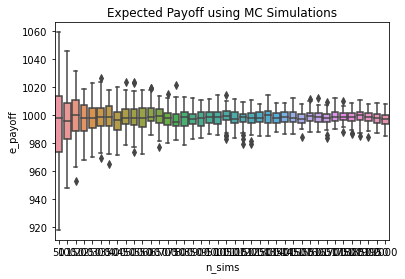

In [136]:
sns.boxplot(data=mc_var_df, x='n_sims', y='e_payoff')
plt.title('Expected Payoff using MC Simulations')
plt.show()

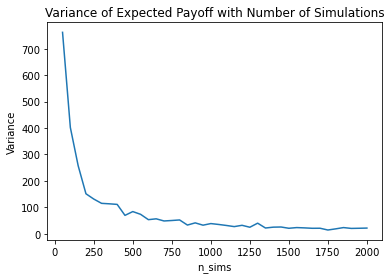

In [137]:
plt.plot(mc_var_df.groupby(by=['n_sims'])['e_payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

### Antithetic Variates

In [138]:
av_var = {}
num_repeats = 100
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    av_var[n_sim] = []
    for i in range(num_repeats):
        experiment_details = {
            'Nsim': n_sim,
            'latest_price_date': '2022-08-19',
            'variance_reduction': True,
            'GBM': 'multivariate',
            'r': 0.045,
            'IV': False,
            'min_sigma':0.0001,
            'max_sigma':5,
            'step':0.00001,
            'error':0.25,
            'EMS': False
        }

        aapl_barrier = 85.760
        amzn_barrier = 69.115
        googl_barrier = 58.605
        aapl_initial = 171.52
        amzn_initial = 138.23
        google_initial = 117.21

        date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
            latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
        trading_days_to_simulate = total_trading_days

        if experiment_details['IV']:

            aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
            aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
            amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
            amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
            googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
            googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

            min_sigma = experiment_details['min_sigma']
            max_sigma = experiment_details['max_sigma']
            error = experiment_details['error']
            step = experiment_details['step']
            sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
            right = len(sigma_hat_list)-1
            left = 0 

        predicted_option_price = []
        expected_payoff_list = []
        aapl_IV_list = []
        amzn_IV_list = []
        googl_IV_list = []

        while date_to_predict <= end_date:

            if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
                date_to_predict += relativedelta(days=+1)
                trading_days_to_simulate -= 1
                hist_end += relativedelta(days=+1)
                alternative_option_ttm-=1
                continue

            hist_start = hist_end - timedelta(days=365)

            aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
            amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
            googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
            temp_df = aapl.merge(amzn, on=['Date'])
            AAG = temp_df.merge(googl, on=['Date'])
            n0 = len(AAG)
            AAGprices = np.array(AAG.drop(columns=['Date']))
            AAGlogprices = np.log(AAGprices)
            AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

            v = np.mean(AAGlogreturns, axis=0)
            Nsim = experiment_details['Nsim']
            T = trading_days_to_simulate
            dt = 1
            m = int(T / dt)
            r = experiment_details['r']

            # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
            if experiment_details['IV']:
                sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
                aapl_IV_list.append(aapl_IV)
                amzn_IV_list.append(amzn_IV)
                googl_IV_list.append(googl_IV)
            else:
                sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

            S0 = AAGprices[0, :]
            sim_aapl = []
            sim_amzn = []
            sim_googl = []

            # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
            if experiment_details['variance_reduction']:
                for i in range(1, int(Nsim/2) + 1):
                    S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_aapl.append(Stilde[0])
                    sim_amzn.append(S[1])
                    sim_amzn.append(Stilde[1])
                    sim_googl.append(S[2])
                    sim_googl.append(Stilde[2])

            else:
                for i in range(1, Nsim + 1):
                    S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                    sim_aapl.append(S[0])
                    sim_amzn.append(S[1])
                    sim_googl.append(S[2])

            if experiment_details['EMS']:
                sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
                sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
                sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

            q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
            q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

            option_prices = []
            payoff_list = []
            for i in range(Nsim):
                option_price, payoff = calculate_option_price(
                        aapl=sim_aapl[i],
                        amzn=sim_amzn[i],
                        googl=sim_googl[i],
                        T=trading_days_to_simulate,
                        total_trading_days=total_trading_days,
                        r=r,
                        q2_index=q2_index,
                        q3_index=q3_index
                    )
                option_prices.append(
                    option_price
                )
                payoff_list.append(payoff)

            expected_payoff_list.append(np.mean(payoff_list))
            av_var[n_sim].append(np.mean(payoff_list))
            option_price = np.mean(option_prices)
            predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [148]:
av_var_dict = []

for n_sim in av_var.keys():
    values = av_var[n_sim]
    for val in values:
        av_var_dict.append({'n_sims': n_sim, 'e_payoff': val})

In [149]:
av_var_df = pd.DataFrame(av_var_dict)

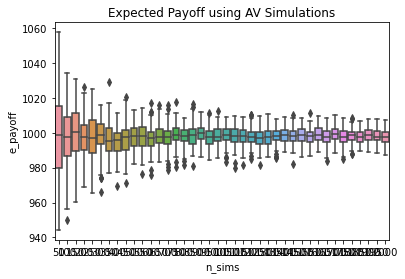

In [150]:
sns.boxplot(data=av_var_df, x='n_sims', y='e_payoff')
plt.title('Expected Payoff using AV Simulations')
plt.show()

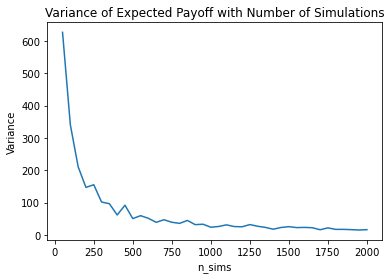

In [151]:
plt.plot(av_var_df.groupby(by=['n_sims'])['e_payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

In [152]:
av_var_df['technique'] = 'AV'

In [153]:
mc_var_df['technique'] = 'MC'

In [154]:
var_df = pd.concat([av_var_df, mc_var_df]).reset_index(drop=True)

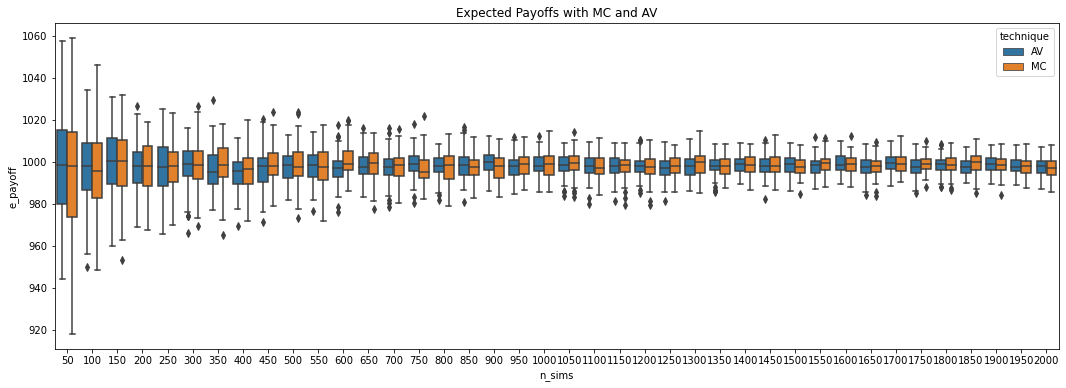

In [157]:
fig = plt.figure(figsize=(18,6))
sns.boxplot(data=var_df, x='n_sims', y='e_payoff', hue='technique')
plt.title('Expected Payoffs with MC and AV')
plt.savefig('../results/MC_vs_AV_expected_payoff')

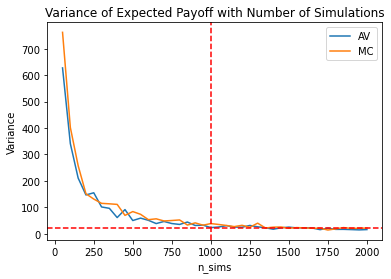

In [167]:
plt.plot(av_var_df.groupby(by=['n_sims'])['e_payoff'].var(), label='AV')
plt.plot(mc_var_df.groupby(by=['n_sims'])['e_payoff'].var(), label='MC')
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.legend(loc='upper right')
plt.axhline(20, color='red', linestyle='dashed')
plt.axvline(1000, color='red', linestyle='dashed')
plt.savefig('../results/MC_vs_AV_variance_expected_payoff')

## Variance of payoff

In [93]:
mc_var_payoff = {}
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    mc_var_payoff[n_sim] = []
    
    experiment_details = {
        'Nsim': n_sim,
        'latest_price_date': '2022-08-19',
        'variance_reduction': False,
        'GBM': 'multivariate',
        'r': 0.045,
        'IV': False,
        'min_sigma':0.0001,
        'max_sigma':5,
        'step':0.00001,
        'error':0.25,
        'EMS': False
    }

    aapl_barrier = 85.760
    amzn_barrier = 69.115
    googl_barrier = 58.605
    aapl_initial = 171.52
    amzn_initial = 138.23
    google_initial = 117.21

    date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
        latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
    trading_days_to_simulate = total_trading_days

    if experiment_details['IV']:

        aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
        aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
        amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
        amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
        googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
        googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

        min_sigma = experiment_details['min_sigma']
        max_sigma = experiment_details['max_sigma']
        error = experiment_details['error']
        step = experiment_details['step']
        sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
        right = len(sigma_hat_list)-1
        left = 0 

    predicted_option_price = []
    expected_payoff_list = []
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    while date_to_predict <= end_date:

        if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1
            continue

        hist_start = hist_end - timedelta(days=365)

        aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
        amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
        googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
        temp_df = aapl.merge(amzn, on=['Date'])
        AAG = temp_df.merge(googl, on=['Date'])
        n0 = len(AAG)
        AAGprices = np.array(AAG.drop(columns=['Date']))
        AAGlogprices = np.log(AAGprices)
        AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

        v = np.mean(AAGlogreturns, axis=0)
        Nsim = experiment_details['Nsim']
        T = trading_days_to_simulate
        dt = 1
        m = int(T / dt)
        r = experiment_details['r']

        # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
        if experiment_details['IV']:
            sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
            aapl_IV_list.append(aapl_IV)
            amzn_IV_list.append(amzn_IV)
            googl_IV_list.append(googl_IV)
        else:
            sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

        S0 = AAGprices[0, :]
        sim_aapl = []
        sim_amzn = []
        sim_googl = []

        # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
        if experiment_details['variance_reduction']:
            for i in range(1, int(Nsim/2) + 1):
                S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_aapl.append(Stilde[0])
                sim_amzn.append(S[1])
                sim_amzn.append(Stilde[1])
                sim_googl.append(S[2])
                sim_googl.append(Stilde[2])

        else:
            for i in range(1, Nsim + 1):
                S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_amzn.append(S[1])
                sim_googl.append(S[2])

        if experiment_details['EMS']:
            sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
            sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
            sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

        q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
        q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

        option_prices = []
        payoff_list = []
        for i in range(Nsim):
            option_price, payoff = calculate_option_price(
                    aapl=sim_aapl[i],
                    amzn=sim_amzn[i],
                    googl=sim_googl[i],
                    T=trading_days_to_simulate,
                    total_trading_days=total_trading_days,
                    r=r,
                    q2_index=q2_index,
                    q3_index=q3_index
                )
            option_prices.append(
                option_price
            )
            payoff_list.append(payoff)

        expected_payoff_list.append(np.mean(payoff_list))
        mc_var_payoff[n_sim] = payoff_list
        option_price = np.mean(option_prices)
        predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [94]:
mc_var_dict = []

for n_sim in mc_var_payoff.keys():
    values = mc_var_payoff[n_sim]
    for val in values:
        mc_var_dict.append({'n_sims': n_sim, 'payoff': val})

In [95]:
mc_var_df = pd.DataFrame(mc_var_dict)

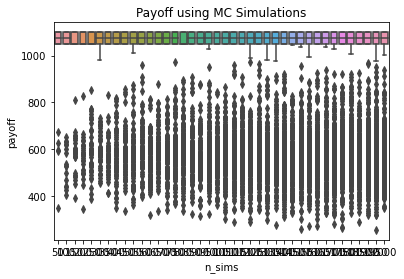

In [96]:
sns.boxplot(data=mc_var_df, x='n_sims', y='payoff')
plt.title('Payoff using MC Simulations')
plt.show()

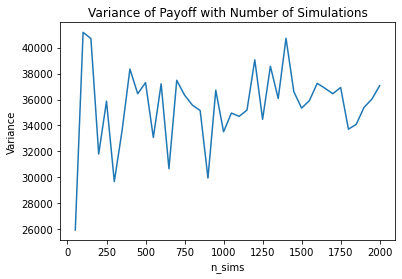

In [97]:
plt.plot(mc_var_df.groupby(by=['n_sims'])['payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Payoff with Number of Simulations')
plt.show()

In [98]:
av_var_payoff = {}
for n_sim in n_sims:
    print(f'No. Of Sims: {n_sim}')
    av_var_payoff[n_sim] = []
    
    experiment_details = {
        'Nsim': n_sim,
        'latest_price_date': '2022-08-19',
        'variance_reduction': True,
        'GBM': 'multivariate',
        'r': 0.045,
        'IV': False,
        'min_sigma':0.0001,
        'max_sigma':5,
        'step':0.00001,
        'error':0.25,
        'EMS': False
    }

    aapl_barrier = 85.760
    amzn_barrier = 69.115
    googl_barrier = 58.605
    aapl_initial = 171.52
    amzn_initial = 138.23
    google_initial = 117.21

    date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
        latest_price_date=experiment_details['latest_price_date'])

#         print(f"date_to_predict: {date_to_predict}")
#         print(f"hist_end: {hist_end}")
#         print(f"end_date: {end_date}")
#         print(f"q2_to_maturity: {q2_to_maturity}")
#         print(f"q3_to_maturity: {q3_to_maturity}")
#         print(f"q2: {q2}")
#         print(f"q3: {q3}")
#         print(f"total_trading_days: {total_trading_days}")
#         print(f"holidays: {holidays}")
    trading_days_to_simulate = total_trading_days

    if experiment_details['IV']:

        aapl_call_option_df = pd.read_csv('../Bloomberg_Data/aapl_call_option.csv')
        aapl_call_option_df['Date'] = pd.to_datetime(aapl_call_option_df['Date'])
        amzn_call_option_df = pd.read_csv('../Bloomberg_Data/amzn_call_option.csv')
        amzn_call_option_df['Date'] = pd.to_datetime(amzn_call_option_df['Date'])
        googl_call_option_df = pd.read_csv('../Bloomberg_Data/googl_call_option.csv')
        googl_call_option_df['Date'] = pd.to_datetime(googl_call_option_df['Date'])

        min_sigma = experiment_details['min_sigma']
        max_sigma = experiment_details['max_sigma']
        error = experiment_details['error']
        step = experiment_details['step']
        sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
        right = len(sigma_hat_list)-1
        left = 0 

    predicted_option_price = []
    expected_payoff_list = []
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    while date_to_predict <= end_date:

        if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
            date_to_predict += relativedelta(days=+1)
            trading_days_to_simulate -= 1
            hist_end += relativedelta(days=+1)
            alternative_option_ttm-=1
            continue

        hist_start = hist_end - timedelta(days=365)

        aapl = extract_data('../data/24-10-2022/aapl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
        amzn = extract_data('../data/24-10-2022/amzn.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
        googl = extract_data('../data/24-10-2022/googl.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
        temp_df = aapl.merge(amzn, on=['Date'])
        AAG = temp_df.merge(googl, on=['Date'])
        n0 = len(AAG)
        AAGprices = np.array(AAG.drop(columns=['Date']))
        AAGlogprices = np.log(AAGprices)
        AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

        v = np.mean(AAGlogreturns, axis=0)
        Nsim = experiment_details['Nsim']
        T = trading_days_to_simulate
        dt = 1
        m = int(T / dt)
        r = experiment_details['r']

        # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
        if experiment_details['IV']:
            sigma,aapl_IV,amzn_IV,googl_IV = calculate_cov_matrix(aapl_call_option_df,amzn_call_option_df,googl_call_option_df,r,alternative_option_ttm,sigma_hat_list,left,right,error,date_to_predict,AAGlogreturns)
            aapl_IV_list.append(aapl_IV)
            amzn_IV_list.append(amzn_IV)
            googl_IV_list.append(googl_IV)
        else:
            sigma = np.cov(AAGlogreturns,rowvar=False)

#             print(f"trading_days_to_simulate: {trading_days_to_simulate}")

        S0 = AAGprices[0, :]
        sim_aapl = []
        sim_amzn = []
        sim_googl = []

        # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
        if experiment_details['variance_reduction']:
            for i in range(1, int(Nsim/2) + 1):
                S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_aapl.append(Stilde[0])
                sim_amzn.append(S[1])
                sim_amzn.append(Stilde[1])
                sim_googl.append(S[2])
                sim_googl.append(Stilde[2])

        else:
            for i in range(1, Nsim + 1):
                S,Z = SimMultiGBM(S0, v, sigma, dt, T)
                sim_aapl.append(S[0])
                sim_amzn.append(S[1])
                sim_googl.append(S[2])

        if experiment_details['EMS']:
            sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
            sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
            sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

        q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
        q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

        option_prices = []
        payoff_list = []
        for i in range(Nsim):
            option_price, payoff = calculate_option_price(
                    aapl=sim_aapl[i],
                    amzn=sim_amzn[i],
                    googl=sim_googl[i],
                    T=trading_days_to_simulate,
                    total_trading_days=total_trading_days,
                    r=r,
                    q2_index=q2_index,
                    q3_index=q3_index
                )
            option_prices.append(
                option_price
            )
            payoff_list.append(payoff)

        expected_payoff_list.append(np.mean(payoff_list))
        av_var_payoff[n_sim] = payoff_list
        option_price = np.mean(option_prices)
        predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
#             print(f"Derivative Price for {date_to_predict}")
#             print(option_price)

        date_to_predict += relativedelta(days=+1)
        trading_days_to_simulate -= 1
        hist_end += relativedelta(days=+1)
        alternative_option_ttm-=1

No. Of Sims: 50
No. Of Sims: 100
No. Of Sims: 150
No. Of Sims: 200
No. Of Sims: 250
No. Of Sims: 300
No. Of Sims: 350
No. Of Sims: 400
No. Of Sims: 450
No. Of Sims: 500
No. Of Sims: 550
No. Of Sims: 600
No. Of Sims: 650
No. Of Sims: 700
No. Of Sims: 750
No. Of Sims: 800
No. Of Sims: 850
No. Of Sims: 900
No. Of Sims: 950
No. Of Sims: 1000
No. Of Sims: 1050
No. Of Sims: 1100
No. Of Sims: 1150
No. Of Sims: 1200
No. Of Sims: 1250
No. Of Sims: 1300
No. Of Sims: 1350
No. Of Sims: 1400
No. Of Sims: 1450
No. Of Sims: 1500
No. Of Sims: 1550
No. Of Sims: 1600
No. Of Sims: 1650
No. Of Sims: 1700
No. Of Sims: 1750
No. Of Sims: 1800
No. Of Sims: 1850
No. Of Sims: 1900
No. Of Sims: 1950
No. Of Sims: 2000


In [99]:
av_var_dict = []

for n_sim in av_var_payoff.keys():
    values = av_var_payoff[n_sim]
    for val in values:
        av_var_dict.append({'n_sims': n_sim, 'payoff': val})

In [100]:
av_var_df = pd.DataFrame(av_var_dict)

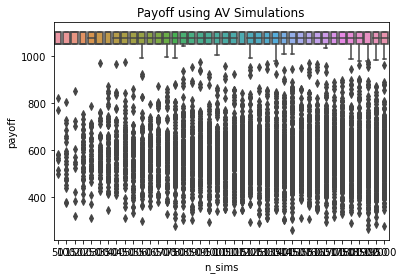

In [101]:
sns.boxplot(data=av_var_df, x='n_sims', y='payoff')
plt.title('Payoff using AV Simulations')
plt.show()

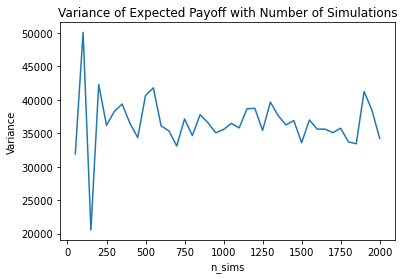

In [102]:
plt.plot(av_var_df.groupby(by=['n_sims'])['payoff'].var())
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Expected Payoff with Number of Simulations')
plt.show()

In [103]:
av_var_df['technique'] = 'AV'

In [104]:
mc_var_df['technique'] = 'MC'

In [105]:
var_df = pd.concat([av_var_df, mc_var_df]).reset_index(drop=True)

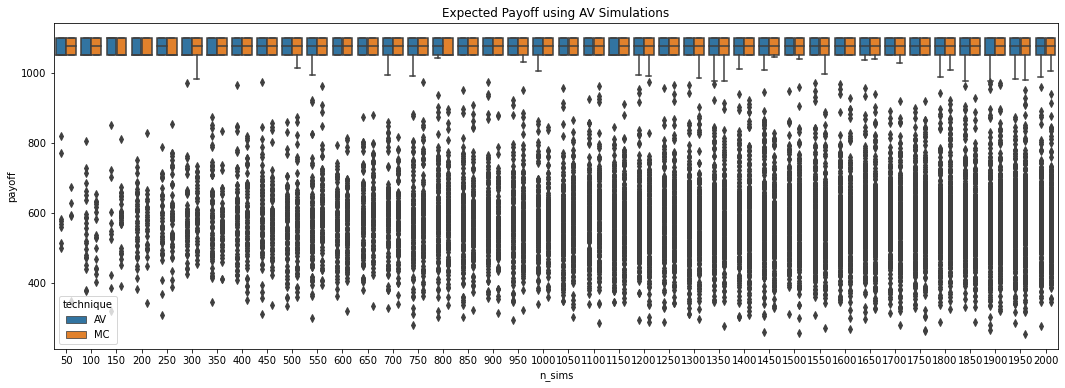

In [106]:
fig = plt.figure(figsize=(18,6))
sns.boxplot(data=var_df, x='n_sims', y='payoff', hue='technique')
plt.title('Expected Payoff using AV Simulations')
plt.show()

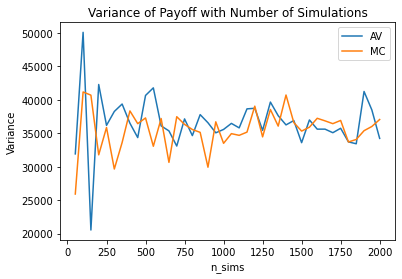

In [107]:
plt.plot(av_var_df.groupby(by=['n_sims'])['payoff'].var(), label='AV')
plt.plot(mc_var_df.groupby(by=['n_sims'])['payoff'].var(), label='MC')
plt.xlabel('n_sims')
plt.ylabel('Variance')
plt.title('Variance of Payoff with Number of Simulations')
plt.legend(loc='upper right')
plt.show()

# Empirical Martingale Correction

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Variance reduction
Derivative Price for 2022-08-19 00:00:00
875.8202549614664
trading_days_to_simulate: 253
Variance reduction
Derivative Price for 2022-08-22 00:00:00
725.8519060762585
trading_days_to_simulate: 252
Variance reduction
Derivative Price for 2022-08-23 00:00:00
821.7690678367037
trading_days_to_simulate: 251
Variance reduction
Derivative Price for 2022-08-24 00:00:00
1065.1282550359426
trading_days_to_simulate: 250
Variance reduction
Derivative Price for 2022-08-25 00:00:00
946.3960133464147
trading_days_to_simulate: 249
Variance reduction
Derivative Price for 2022-08-26 00:00:00
769.2349356072607
tradin

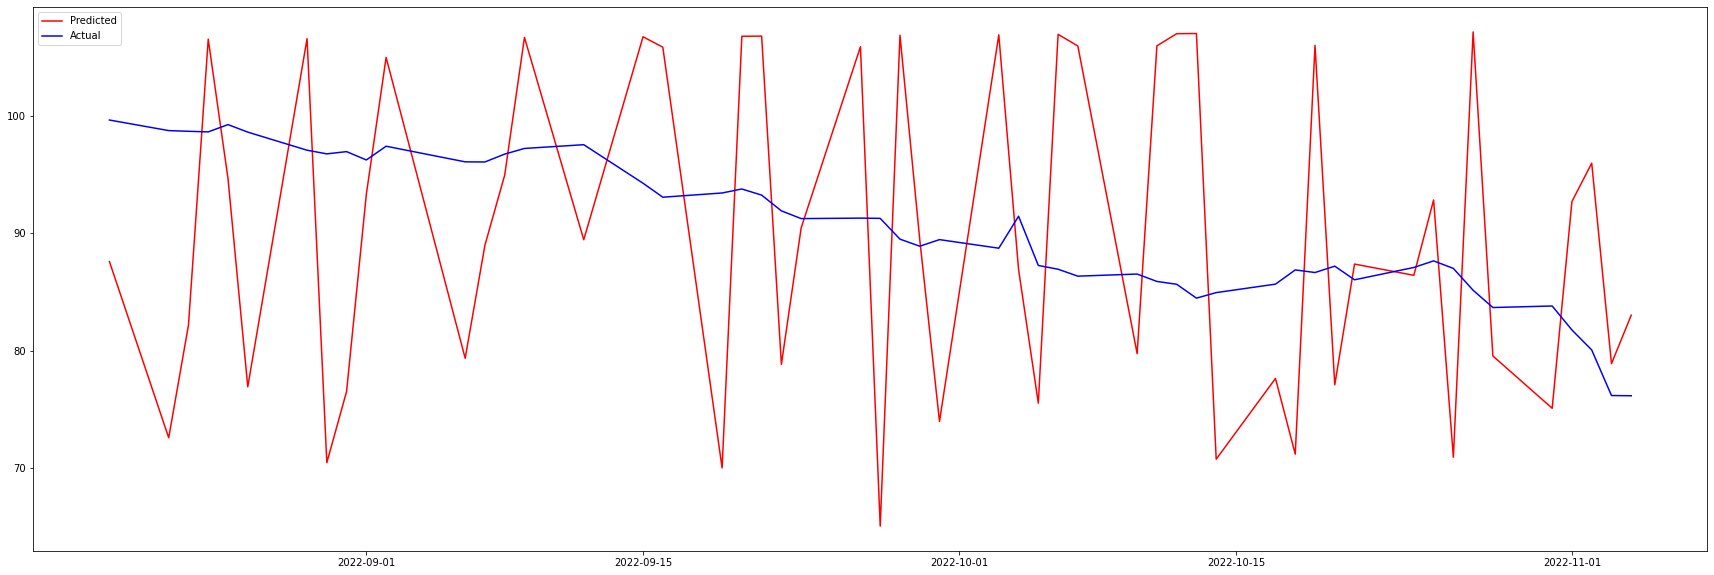

In [5]:
experiment_details = {
    'Nsim': 2,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':False,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': True,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []

aapl_before_emc = []
amzn_before_emc = []
googl_before_emc = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        print('Variance reduction')
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])
    
    aapl_before_emc = sim_aapl
    amzn_before_emc = sim_amzn
    googl_before_emc = sim_googl
    
    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

### AAPL EMC

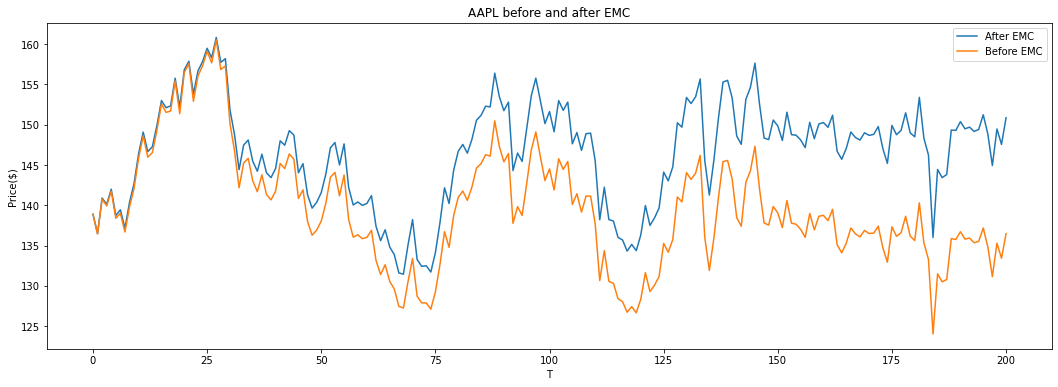

In [6]:
fig = plt.figure(figsize=(18,6))
plt.plot(sim_aapl[1], label='After EMC')
plt.plot(aapl_before_emc[1], label='Before EMC')
plt.title('AAPL before and after EMC')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.legend(loc='upper right')
plt.savefig('../results/AAPL_before_after_EMC')

### AMZN EMC

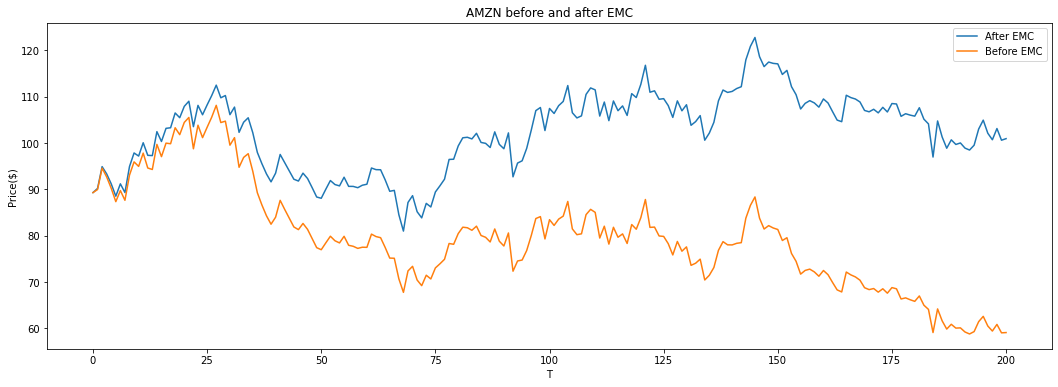

In [7]:
fig = plt.figure(figsize=(18,6))
plt.plot(sim_amzn[1], label='After EMC')
plt.plot(amzn_before_emc[1], label='Before EMC')
plt.title('AMZN before and after EMC')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.legend(loc='upper right')
plt.savefig('../results/AMZN_before_after_EMC')

### GOOGL EMC

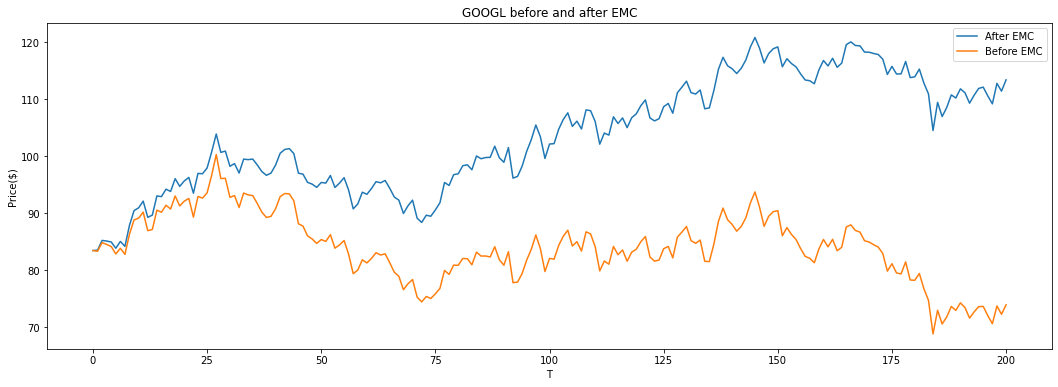

In [8]:
fig = plt.figure(figsize=(18,6))
plt.plot(sim_googl[1], label='After EMC')
plt.plot(googl_before_emc[1], label='Before EMC')
plt.title('GOOGL before and after EMC')
plt.xlabel('T')
plt.ylabel('Price($)')
plt.legend(loc='upper right')
plt.savefig('../results/GOOGL_before_after_EMC')

# Interest Rates

In [9]:
rates = pd.read_csv('../data/04-11-2022/USTREASURY-YIELD_04_11_22.csv')

In [10]:
rates['Date'] = pd.to_datetime(rates['Date'],format='%Y-%m-%d')

In [11]:
rates = rates.set_index('Date')
rates = rates.asfreq('D')
rates = rates.ffill()

In [12]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11995 entries, 1990-01-02 to 2022-11-04
Freq: D
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 MO    7767 non-null   float64
 1   2 MO    1481 non-null   float64
 2   3 MO    11995 non-null  float64
 3   6 MO    11995 non-null  float64
 4   1 YR    11995 non-null  float64
 5   2 YR    11995 non-null  float64
 6   3 YR    11995 non-null  float64
 7   5 YR    11995 non-null  float64
 8   7 YR    11995 non-null  float64
 9   10 YR   11995 non-null  float64
 10  20 YR   10627 non-null  float64
 11  30 YR   11995 non-null  float64
dtypes: float64(12)
memory usage: 1.2 MB


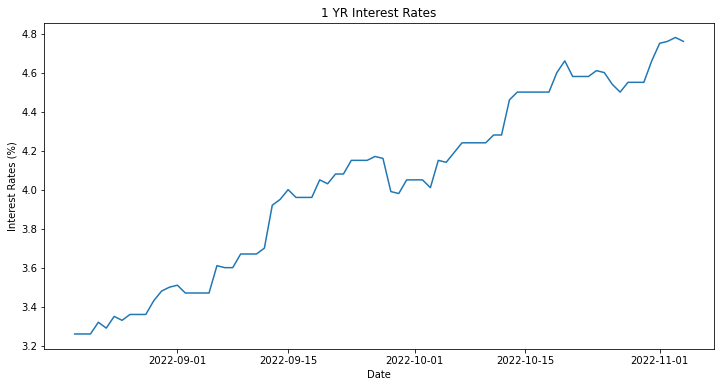

In [16]:
fig = plt.figure(figsize=(12,6))
plt.plot(rates.loc['2022-08-19':, '1 YR'])
plt.xlabel('Date')
plt.ylabel('Interest Rates (%)')
plt.title('1 YR Interest Rates')
plt.savefig('../results/1YR_interest_rates')

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
985.0361109737819
trading_days_to_simulate: 253
Derivative Price for 2022-08-22 00:00:00
994.1567526194927
trading_days_to_simulate: 252
Derivative Price for 2022-08-23 00:00:00
984.3860382548573
trading_days_to_simulate: 251
Derivative Price for 2022-08-24 00:00:00
996.727494540436
trading_days_to_simulate: 250
Derivative Price for 2022-08-25 00:00:00
997.5509547799437
trading_days_to_simulate: 249
Derivative Price for 2022-08-26 00:00:00
998.9516840949426
trading_days_to_simulate: 248
Derivative Price for 2022-08-29 00:00:00
972.3416739678755
trading_days_to_simulate: 247
Der

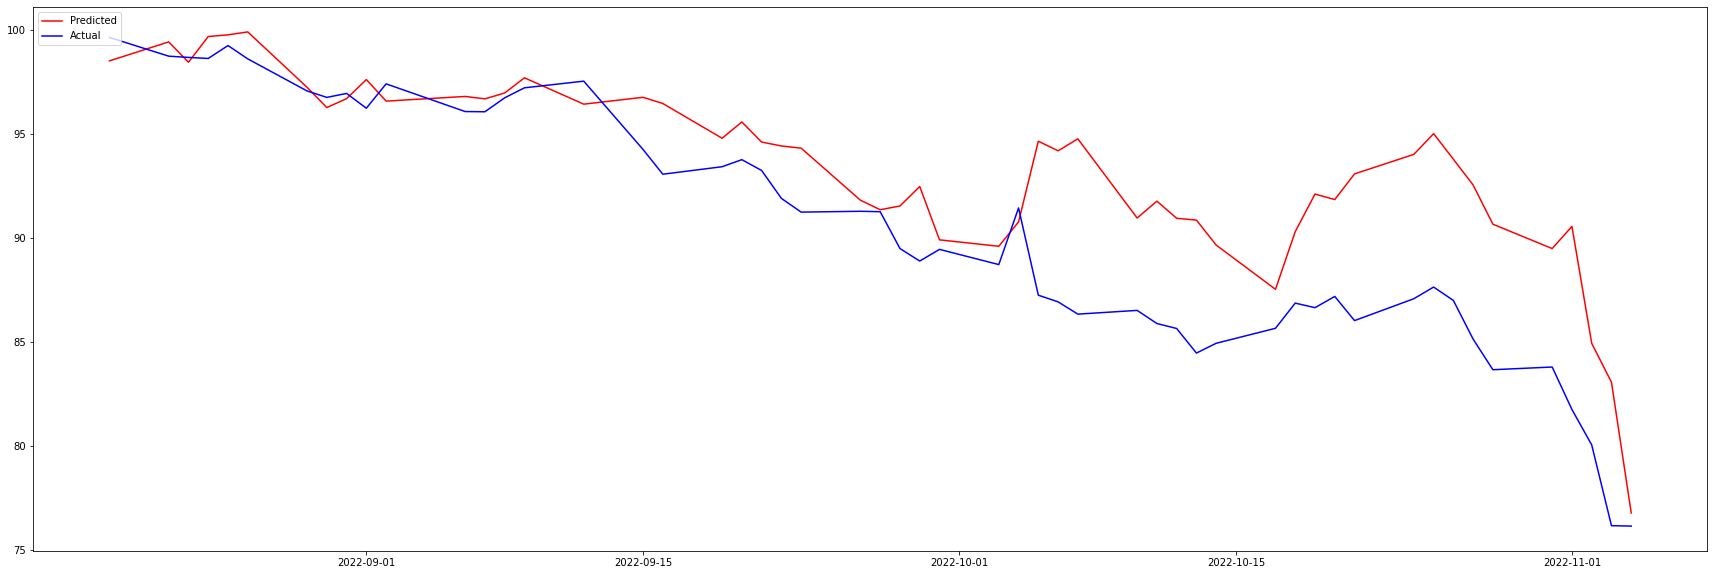

In [20]:
experiment_details = {
    'Nsim': 1000,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
#     'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':True,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': True,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []


while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])
    
    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
970.1786800380261
trading_days_to_simulate: 253
Derivative Price for 2022-08-22 00:00:00
954.6679938668923
trading_days_to_simulate: 252
Derivative Price for 2022-08-23 00:00:00
950.9167274146793
trading_days_to_simulate: 251
Derivative Price for 2022-08-24 00:00:00
953.0801025574908
trading_days_to_simulate: 250
Derivative Price for 2022-08-25 00:00:00
950.955480116199
trading_days_to_simulate: 249
Derivative Price for 2022-08-26 00:00:00
959.9693345596497
trading_days_to_simulate: 248
Derivative Price for 2022-08-29 00:00:00
926.0991577115357
trading_days_to_simulate: 247
Der

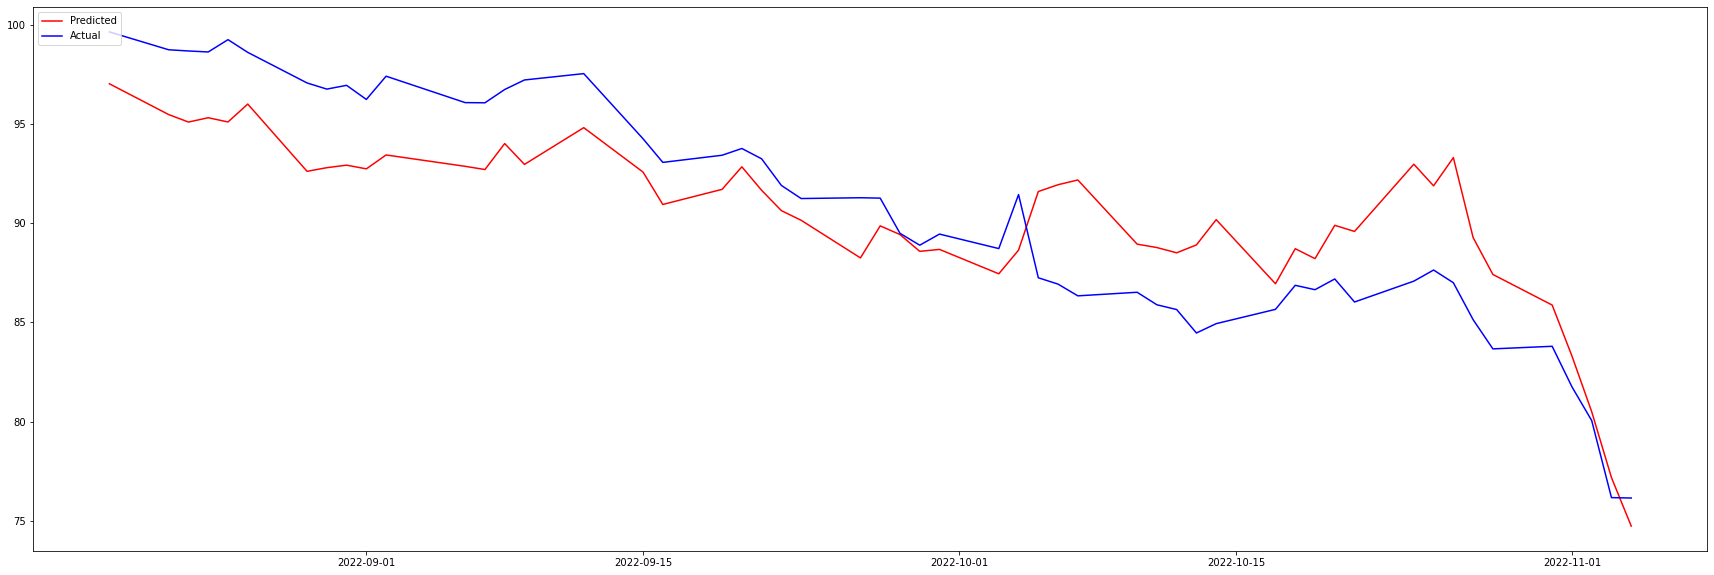

In [31]:
experiment_details = {
    'Nsim': 1000,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
#     'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':False,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': True,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []

historical_v = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=300)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    historical_v.append(v)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

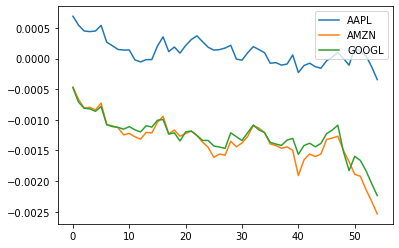

In [25]:
plt.plot(historical_v, label=['AAPL','AMZN','GOOGL'])
plt.legend(loc='upper right')

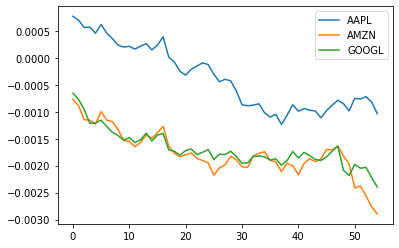

In [30]:
plt.plot(historical_v, label=['AAPL','AMZN','GOOGL'])
plt.legend(loc='upper right')

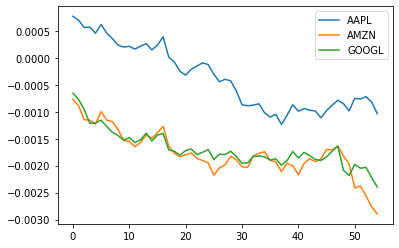

In [32]:
plt.plot(historical_v, label=['AAPL','AMZN','GOOGL'])
plt.legend(loc='upper right')